In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

data_dir = "/content/drive/My Drive/TCIA_Data/images/Spine-Mets-CT-SEG"

patient_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
patient_folders.sort()
print(patient_folders)


['10250', '10352', '10355', '10456', '10458', '10543', '11084', '11471', '12196', '12459', '12855', '13055', '13089', '13627', '13641', '13643', '13653', '13662', '13681', '13683', '13697', '13800', '13819', '13838', '13843', '13977', '13989', '14078', '14089', '14138', '14151', '14293', '14313', '14316', '14427', '14434', '14439', '14445', '14487', '14636', '14638', '14643', '14650', '14655', '14659', '14797', '14826', '14874', '14912', '15001', '15027', '15040', '15041', '15067', '15094']


In [4]:
print(f"Total patients: {len(patient_folders)}")

Total patients: 55


In [5]:
# Data Statistics
image_counts = {}
for patient in patient_folders:
    patient_dir = os.path.join(data_dir, patient)
    images = [f for f in os.listdir(patient_dir) if f.endswith(".jpg")]
    image_counts[patient] = len(images)

In [6]:
#Dictionary of patient folder mapped to its image counts
print(image_counts)

{'10250': 797, '10352': 1134, '10355': 451, '10456': 797, '10458': 390, '10543': 797, '11084': 969, '11471': 797, '12196': 399, '12459': 797, '12855': 651, '13055': 527, '13089': 508, '13627': 430, '13641': 797, '13643': 532, '13653': 2124, '13662': 522, '13681': 399, '13683': 797, '13697': 817, '13800': 221, '13819': 797, '13838': 797, '13843': 242, '13977': 412, '13989': 527, '14078': 350, '14089': 332, '14138': 574, '14151': 797, '14293': 537, '14313': 797, '14316': 399, '14427': 797, '14434': 590, '14439': 450, '14445': 797, '14487': 477, '14636': 435, '14638': 544, '14643': 522, '14650': 797, '14655': 399, '14659': 397, '14797': 797, '14826': 793, '14874': 399, '14912': 797, '15001': 517, '15027': 495, '15040': 797, '15041': 399, '15067': 797, '15094': 1317}


In [7]:
total_images = sum(image_counts.values())
avg_images_per_patients = total_images/len(patient_folders)
min_images = min(image_counts.values())
max_images = max(image_counts.values())

In [8]:
print(total_images)
print(avg_images_per_patients)
print(min_images)
print(max_images)

35527
645.9454545454546
221
2124


In [9]:
csv_path = "/content/drive/MyDrive/TCIA_Data/Spine_Data_Copy.csv"
labels_df = pd.read_csv(csv_path)

In [10]:
print("Column names in CSV:", labels_df.columns.tolist())

#Map Patient/Case Number to the Lesion label as per csv file
label_dict = dict(zip(labels_df["Case"].astype(str), labels_df["Vertebrae with Majority Lesions"]))

Column names in CSV: ['Case', 'Age (Y)', 'Sex', 'Height (m)', 'Weight (kg)', 'BMI (kg/m^2)', 'Primary cancer', 'Vertebrae with Lesions', 'Vertebrae with Majority Lesions', 'Blastic', 'Lytic', 'Mixed', 'Comments/Fractures']


In [11]:
print(label_dict)

{'10250.0': 'Mixed lesion', '10352.0': 'No lesions observed', '10355.0': 'Mixed lesion', '10456.0': 'Lytic lesion', '10458.0': 'Blastic lesion', '10543.0': 'Blastic lesion', '11084.0': 'Lytic lesion', '11471.0': 'Lytic lesion', '12196.0': 'Blastic lesion', '12459.0': 'No lesions observed', '12855.0': 'Mixed lesion', '13055.0': 'Mixed lesion', '13089.0': 'Mixed lesion', '13627.0': 'Lytic lesion', '13641.0': 'Blastic lesion', '13643.0': 'Blastic lesion', '13653.0': 'Lytic lesion', '13662.0': 'Blastic lesion', '13681.0': 'No lesions observed', '13683.0': 'Lytic lesion', '13697.0': 'Blastic lesion', '13800.0': 'Mixed lesion', '13819.0': 'Lytic lesion', '13838.0': 'No lesions observed', '13843.0': 'Lytic lesion', '13977.0': 'No lesions observed', '13989.0': 'Mixed lesion', '14078.0': 'Lytic lesion', '14089.0': 'No lesions observed', '14138.0': 'Lytic lesion', '14151.0': 'Lytic lesion', '14293.0': 'No lesions observed', '14313.0': 'Blastic lesion', '14316.0': 'No lesions observed', '14427.0'

In [12]:
label_counts = Counter(label_dict.values())
print(label_counts)

Counter({'Lytic lesion': 19, 'Blastic lesion': 18, 'Mixed lesion': 9, 'No lesions observed': 9, nan: 1})


In [13]:
print("\nLabel Distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} patients")


Label Distribution:
Mixed lesion: 9 patients
No lesions observed: 9 patients
Lytic lesion: 19 patients
Blastic lesion: 18 patients
nan: 1 patients


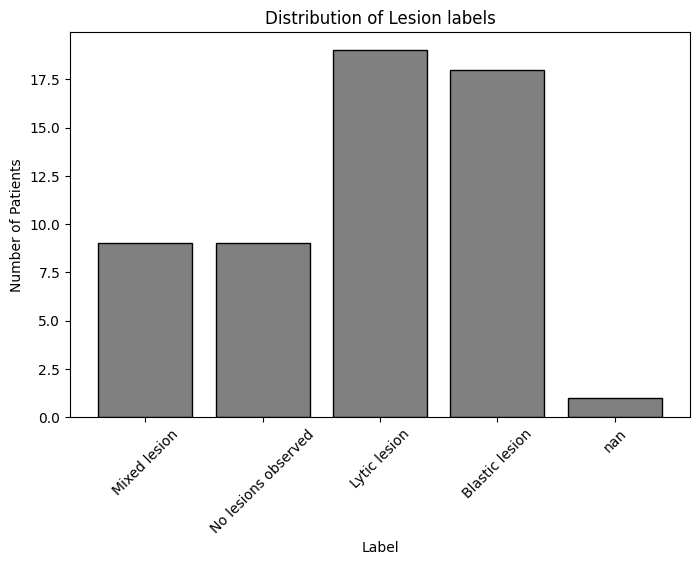

In [14]:
label_keys = [str(key) for key in label_counts.keys()]

plt.figure(figsize=(8, 5))
plt.bar(label_keys, label_counts.values(), color='gray', edgecolor='black')
plt.title("Distribution of Lesion labels")
plt.xlabel("Label")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.show()

In [15]:
#Makes sure the images inside each patient folder are in order
time_sorted_images = {}
for patient in patient_folders:
    patient_dir = os.path.join(data_dir, patient)
    images = [f for f in os.listdir(patient_dir) if f.endswith(".jpg")]
    images.sort()
    time_sorted_images[patient] = [os.path.join(patient_dir, img) for img in images]


In [16]:
sequence_length = 16
target_size = (224,224)

In [17]:
import pickle
from google.colab import files
import shutil

Preprocessing Images

In [ ]:
# Directory to save individual sequences (in Colab's local runtime)
sequences_dir = "/content/processed_sequences"
if not os.path.exists(sequences_dir):
    os.makedirs(sequences_dir)

# File to save the mapping of patients to their sequence files (also in Colab's local runtime)
mapping_file = "/content/sequence_mapping.pkl"

# Load existing sequence mapping if it exists, otherwise start fresh
if os.path.exists(mapping_file):
    print("Loading existing sequence mapping to resume processing...")
    with open(mapping_file, "rb") as f:
        sequence_mapping = pickle.load(f)
else:
    sequence_mapping = {}




#Process images and save sequences incrementally
total_sequences = 0
for patient, image_paths in time_sorted_images.items():
    # Skip this patient if already processed
    if patient in sequence_mapping:
        print(f"Skipping patient {patient}: already processed.")
        total_sequences += len(sequence_mapping[patient])
        continue

    print(f"Processing patient {patient}...")
    patient_sequences = []  # List to store filenames of sequences for this patient
    total_images = len(image_paths)

    # Process images in chunks of sequence_length
    for start in range(0, total_images - sequence_length + 1, sequence_length):
        # Check if this sequence has already been processed
        sequence_id = f"{patient}_{start//sequence_length}"
        sequence_file = os.path.join(sequences_dir, f"{sequence_id}.npy")

        if os.path.exists(sequence_file):
            print(f"Skipping sequence {sequence_id}: already exists.")
            patient_sequences.append(sequence_file)
            total_sequences += 1
            continue

        # Load only the images needed for this sequence
        arrays = []
        for i in range(start, start + sequence_length):
            img_path = image_paths[i]
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

            if img is None:  # Check if image was loaded
                print(f"Warning: Could not read {img_path}")
                break  # Skip this sequence if any image fails

            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)  # Resize
            img = img.astype(np.float32) / 255.0  # Normalize and use float32
            arrays.append(img)

        # If we successfully loaded all images for this sequence
        if len(arrays) == sequence_length:
            # Create the sequence
            seq = np.stack(arrays, axis=0)
            seq = np.expand_dims(seq, axis=-1)
            seq = np.repeat(seq, 3, axis=-1)

            # Save the sequence as a .npy file
            np.save(sequence_file, seq)
            patient_sequences.append(sequence_file)
            total_sequences += 1

    #Save the patient's sequences to the mapping
    sequence_mapping[patient] = patient_sequences

    #Save the updated mapping after each patient
    with open(mapping_file, "wb") as f:
        pickle.dump(sequence_mapping, f)
    print(f"Updated sequence mapping saved after processing patient {patient}.")

print(f"Processing complete. Total sequences created: {total_sequences}")
print(f"Final sequence mapping saved to {mapping_file}")

#Zip the processed_sequences folder and download it
zip_file = "/content/processed_sequences.zip"
shutil.make_archive("/content/processed_sequences", 'zip', sequences_dir)

# Download the zip file to your local computer
files.download(zip_file)
print("Downloading processed_sequences.zip to your local computer...")

# Download the sequence_mapping.pkl file
files.download(mapping_file)
print("Downloading sequence_mapping.pkl to your local computer...")

Processing patient 10250...
Updated sequence mapping saved after processing patient 10250.
Processing patient 10352...
Updated sequence mapping saved after processing patient 10352.
Processing patient 10355...
Updated sequence mapping saved after processing patient 10355.
Processing patient 10456...
Updated sequence mapping saved after processing patient 10456.
Processing patient 10458...
Updated sequence mapping saved after processing patient 10458.
Processing patient 10543...
Updated sequence mapping saved after processing patient 10543.
Processing patient 11084...
Updated sequence mapping saved after processing patient 11084.
Processing patient 11471...
Updated sequence mapping saved after processing patient 11471.
Processing patient 12196...
Updated sequence mapping saved after processing patient 12196.
Processing patient 12459...
Updated sequence mapping saved after processing patient 12459.
Processing patient 12855...
Updated sequence mapping saved after processing patient 12855.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Uploading the images to Drive

In [ ]:
base_dir = "/content/drive/My Drive/TCIA_Data"
destination_dir = os.path.join(base_dir, "processed_data")
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)
    print(f"Created directory: {destination_dir}")
else:
    print(f"Directory already exists: {destination_dir}")

Directory already exists: /content/drive/My Drive/TCIA_Data/processed_data


In [ ]:
uploaded = files.upload()

#Saving pkl file
pkl_destination = os.path.join(destination_dir, "sequence_mapping.pkl")
with open(pkl_destination, "wb") as f:
    f.write(uploaded["sequence_mapping.pkl"])

print(f"Saved sequence_mapping.pkl to {pkl_destination}")

KeyboardInterrupt: 

In [ ]:
uploaded = files.upload()

#Saving sequences
zip_destination = os.path.join(destination_dir, "processed_sequences.zip")
with open(zip_destination, "wb") as f:
    f.write(uploaded["processed_sequences.zip"])

print(f"Saved processed_sequences.zip to {zip_destination}")


Saving processed_sequences.zip to processed_sequences.zip
Saved processed_sequences.zip to /content/drive/My Drive/TCIA_Data/processed_data/processed_sequences.zip


Preparing Data and Feeding to Input Pipeline

In [18]:
base_dir = "/content/drive/My Drive/TCIA_Data"
source_dir = os.path.join(base_dir, "processed_data")
zip_file = os.path.join(source_dir, "processed_sequences.zip")
mapping_file = os.path.join(source_dir, "sequence_mapping.pkl")

In [19]:
!unzip -o "/content/drive/MyDrive/TCIA_Data/processed_data/processed_sequences.zip" -d "/content"

Archive:  /content/drive/MyDrive/TCIA_Data/processed_data/processed_sequences.zip
  inflating: /content/15040_5.npy    
  inflating: /content/15040_12.npy   
  inflating: /content/14638_5.npy    
  inflating: /content/13683_18.npy   
  inflating: /content/14427_47.npy   
  inflating: /content/14151_48.npy   
  inflating: /content/11084_39.npy   
  inflating: /content/11084_41.npy   
  inflating: /content/14636_23.npy   
  inflating: /content/13838_44.npy   
  inflating: /content/14912_47.npy   
  inflating: /content/14659_15.npy   
  inflating: /content/10352_27.npy   
  inflating: /content/14316_17.npy   
  inflating: /content/13681_16.npy   
  inflating: /content/14650_18.npy   
  inflating: /content/14487_14.npy   
  inflating: /content/12196_1.npy    
  inflating: /content/13838_39.npy   
  inflating: /content/10352_23.npy   
  inflating: /content/10543_8.npy    
  inflating: /content/13653_129.npy  
  inflating: /content/13819_43.npy   
  inflating: /content/13641_40.npy   
  infl

In [20]:
#Load the mapping and labels
with open(mapping_file, "rb") as f:
    sequence_mapping = pickle.load(f)

In [21]:
# Update paths
sequences_dir = "/content"
sequence_mapping = {
    str(patient): [os.path.join(sequences_dir, os.path.basename(f)) for f in files if os.path.exists(os.path.join(sequences_dir, os.path.basename(f)))]
    for patient, files in sequence_mapping.items()
}

In [22]:
print(sequence_mapping)

{'10250': ['/content/10250_0.npy', '/content/10250_1.npy', '/content/10250_2.npy', '/content/10250_3.npy', '/content/10250_4.npy', '/content/10250_5.npy', '/content/10250_6.npy', '/content/10250_7.npy', '/content/10250_8.npy', '/content/10250_9.npy', '/content/10250_10.npy', '/content/10250_11.npy', '/content/10250_12.npy', '/content/10250_13.npy', '/content/10250_14.npy', '/content/10250_15.npy', '/content/10250_16.npy', '/content/10250_17.npy', '/content/10250_18.npy', '/content/10250_19.npy', '/content/10250_20.npy', '/content/10250_21.npy', '/content/10250_22.npy', '/content/10250_23.npy', '/content/10250_24.npy', '/content/10250_25.npy', '/content/10250_26.npy', '/content/10250_27.npy', '/content/10250_28.npy', '/content/10250_29.npy', '/content/10250_30.npy', '/content/10250_31.npy', '/content/10250_32.npy', '/content/10250_33.npy', '/content/10250_34.npy', '/content/10250_35.npy', '/content/10250_36.npy', '/content/10250_37.npy', '/content/10250_38.npy', '/content/10250_39.npy',

In [23]:
labels_df["Case"] = labels_df["Case"].astype(str).str.strip().str.split('.').str[0]

In [24]:
label_dict = dict(zip(labels_df["Case"].astype(str), labels_df["Vertebrae with Majority Lesions"]))

In [25]:
print(label_dict)

{'10250': 'Mixed lesion', '10352': 'No lesions observed', '10355': 'Mixed lesion', '10456': 'Lytic lesion', '10458': 'Blastic lesion', '10543': 'Blastic lesion', '11084': 'Lytic lesion', '11471': 'Lytic lesion', '12196': 'Blastic lesion', '12459': 'No lesions observed', '12855': 'Mixed lesion', '13055': 'Mixed lesion', '13089': 'Mixed lesion', '13627': 'Lytic lesion', '13641': 'Blastic lesion', '13643': 'Blastic lesion', '13653': 'Lytic lesion', '13662': 'Blastic lesion', '13681': 'No lesions observed', '13683': 'Lytic lesion', '13697': 'Blastic lesion', '13800': 'Mixed lesion', '13819': 'Lytic lesion', '13838': 'No lesions observed', '13843': 'Lytic lesion', '13977': 'No lesions observed', '13989': 'Mixed lesion', '14078': 'Lytic lesion', '14089': 'No lesions observed', '14138': 'Lytic lesion', '14151': 'Lytic lesion', '14293': 'No lesions observed', '14313': 'Blastic lesion', '14316': 'No lesions observed', '14427': 'Lytic lesion', '14434': 'Lytic lesion', '14439': 'Blastic lesion', 

In [26]:
sequence_files=[]
labels =[]


In [27]:
for patient, seq_files in sequence_mapping.items():
    if patient in label_dict:
        for seq_file in seq_files:
            sequence_files.append(seq_file)
            labels.append(label_dict[patient])

In [28]:
print(sequence_files)
print(labels)

['/content/10250_0.npy', '/content/10250_1.npy', '/content/10250_2.npy', '/content/10250_3.npy', '/content/10250_4.npy', '/content/10250_5.npy', '/content/10250_6.npy', '/content/10250_7.npy', '/content/10250_8.npy', '/content/10250_9.npy', '/content/10250_10.npy', '/content/10250_11.npy', '/content/10250_12.npy', '/content/10250_13.npy', '/content/10250_14.npy', '/content/10250_15.npy', '/content/10250_16.npy', '/content/10250_17.npy', '/content/10250_18.npy', '/content/10250_19.npy', '/content/10250_20.npy', '/content/10250_21.npy', '/content/10250_22.npy', '/content/10250_23.npy', '/content/10250_24.npy', '/content/10250_25.npy', '/content/10250_26.npy', '/content/10250_27.npy', '/content/10250_28.npy', '/content/10250_29.npy', '/content/10250_30.npy', '/content/10250_31.npy', '/content/10250_32.npy', '/content/10250_33.npy', '/content/10250_34.npy', '/content/10250_35.npy', '/content/10250_36.npy', '/content/10250_37.npy', '/content/10250_38.npy', '/content/10250_39.npy', '/content

In [29]:
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

In [30]:
print("Unique encoded labels:", np.unique(labels))

Unique encoded labels: [0 1 2 3]


In [31]:
from tensorflow.keras.utils import to_categorical

In [32]:
train_labels_one_hot = to_categorical(labels, num_classes=4)
train_files_repeated = sequence_files * len(np.unique(labels[0]))

In [33]:
train_files_temp, test_files, train_labels_temp, test_labels = train_test_split(
    train_files_repeated, train_labels_one_hot, test_size=0.2, random_state=42
)

In [34]:
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files_temp, train_labels_temp, test_size=0.2, random_state=42  # 20% of training data for validation
)

In [35]:
import tensorflow as tf

In [36]:
def load_sequence(file_path, label):
    seq = np.load(file_path.decode('utf-8'))
    seq = tf.cast(seq, tf.float32)
    label = tf.cast(label, tf.float32)
    return seq, label

In [37]:
# Training Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset = train_dataset.map(
    lambda x, y: tf.numpy_function(load_sequence, [x, y], [tf.float32, tf.float32]),
    num_parallel_calls=tf.data.AUTOTUNE

)
train_dataset = train_dataset.batch(32)  # Add batch before shape ensuring
train_dataset = train_dataset.map(
    lambda seq, label: (
        tf.ensure_shape(seq, [None, 16, 224, 224, 3]),
        tf.ensure_shape(label, [None, 4])
    )
)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [38]:
# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset = val_dataset.map(
    lambda x, y: tf.numpy_function(load_sequence, [x, y], [tf.float32, tf.float32]),
    num_parallel_calls=tf.data.AUTOTUNE
)
val_dataset = val_dataset.batch(32)
val_dataset = val_dataset.map(
    lambda seq, label: (
        tf.ensure_shape(seq, [None, 16, 224, 224, 3]),
        tf.ensure_shape(label, [None, 4])
    )
)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)


In [39]:
# Testing dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
test_dataset = test_dataset.map(
    lambda x, y: tf.numpy_function(load_sequence, [x, y], [tf.float32, tf.float32]),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.map(
    lambda seq, label: (
        tf.ensure_shape(seq, [16, 224, 224, 3]),
        tf.ensure_shape(label, [4])
    )
)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)  # Add batch size before prefetch

In [40]:
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")
print(f"Testing samples: {len(test_files)}")

Training samples: 1388
Validation samples: 348
Testing samples: 435


Model Creation

In [41]:
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Activation
from tensorflow.keras.models import Model

In [42]:
def inception_3d_block(x, f1x1, f3x3_reduce, f3x3, f5x5_reduce, f5x5, fpool):
    #Path 1: 1x1x1 Convolution (Extracts basic features)**
    path1 = Conv3D(f1x1, (1, 1, 1), padding='same')(x)
    path1 = Activation('relu')(path1)

    #Path 2: 1x1x1 → 3x3x3 Convolution (Captures mid-range features)**
    path2 = Conv3D(f3x3_reduce, (1, 1, 1), padding='same')(x)  # Reduce depth
    path2 = Activation('relu')(path2)
    path2 = Conv3D(f3x3, (3, 3, 3), padding='same')(path2)  # 3D conv
    path2 = Activation('relu')(path2)

    #Path 3: 1x1x1 → 5x5x5 Convolution (Captures larger features)**
    path3 = Conv3D(f5x5_reduce, (1, 1, 1), padding='same')(x)  # Reduce depth
    path3 = Activation('relu')(path3)
    path3 = Conv3D(f5x5, (5, 5, 5), padding='same')(path3)  # 5x5x5 3D conv
    path3 = Activation('relu')(path3)

    #Path 4: 3x3x3 Max Pool → 1x1x1 Convolution (Captures background information)**
    path4 = MaxPooling3D((3, 3, 3), strides=(1, 1, 1), padding='same')(x)  # 3D pooling
    path4 = Conv3D(fpool, (1, 1, 1), padding='same')(path4)  # 1x1x1 conv after pooling
    path4 = Activation('relu')(path4)

    # Final Step: Concatenate all paths**
    return concatenate([path1, path2, path3, path4], axis=-1)  # Merge features


In [43]:
from tensorflow.keras.layers import GlobalAveragePooling3D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [44]:
def SimpleI3DNet(input_shape=(sequence_length, 224,224, 3), num_classes=4):

    inputs = Input(shape=input_shape)

    # Initial 3D Convolution & Pooling
    x = Conv3D(64, (7, 7, 7), strides=(2, 2, 2), padding='same')(inputs)
    x = Activation('relu')(x)
    x = MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same')(x)

    # First I3D Inception Block
    x = inception_3d_block(x, 64, 96, 128, 16, 32, 32)

    # Second I3D Inception Block
    x = inception_3d_block(x, 128, 128, 192, 32, 96, 64)

    # Pooling layer
    x = MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same')(x)

    # Third I3D Inception Block
    x = inception_3d_block(x, 192, 96, 208, 16, 48, 64)

    # Global Average Pooling
    x = GlobalAveragePooling3D()(x)
    x = Dropout(0.5)(x)

    # Fully connected layer for classification
    x = Dense(num_classes, activation='softmax')(x)


    # Define the model
    model = Model(inputs=inputs, outputs=x)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [45]:
model = SimpleI3DNet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16, 224,   │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 8, 112,    │     65,920 │ input_layer[0][0] │
│                     │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 8, 112,    │          0 │ conv3d[0][0]      │
│ (Activation)        │ 112, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 4, 56, 56, │          0 │ activation[0][0]  │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 4, 56, 56, │      6,240 │ max_pooling3d[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 4, 56, 56, │      1,040 │ max_pooling3d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 4, 56, 56, │          0 │ conv3d_2[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 4, 56, 56, │          0 │ conv3d_4[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 4, 56, 56, │          0 │ max_pooling3d[0]… │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 4, 56, 56, │      4,160 │ max_pooling3d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 4, 56, 56, │    331,904 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 4, 56, 56, │     64,032 │ activation_4[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 4, 56, 56, │      2,080 │ max_pooling3d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 4, 56, 56, │          0 │ conv3d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 4, 56, 56, │          0 │ conv3d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 4, 56, 56, │          0 │ conv3d_5[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 4, 56, 56, │          0 │ conv3d_6[0][0]  

 Total params: 2,428,132 (9.26 MB)

 Trainable params: 2,428,132 (9.26 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [51]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.8235963581183612), 1: np.float64(0.6217067583046965), 2: np.float64(1.68555900621118), 3: np.float64(1.7121451104100947)}


In [53]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 182s 4s/step - accuracy: 0.3033 - loss: 1.3329 - val_accuracy: 0.2299 - val_loss: 1.3465
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 197s 5s/step - accuracy: 0.3180 - loss: 1.3337 - val_accuracy: 0.2328 - val_loss: 1.3485
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.2725 - loss: 1.3296 - val_accuracy: 0.2241 - val_loss: 1.3436
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.3191 - loss: 1.3217 - val_accuracy: 0.2615 - val_loss: 1.3345
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.3358 - loss: 1.3012 - val_accuracy: 0.2730 - val_loss: 1.3067
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.3396 - loss: 1.2705 - val_accuracy: 0.2443 - val_loss: 1.3288
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 182s 4s/step - accuracy: 0.3196 - loss: 1.2654 - val_accuracy: 0.3046 - val_loss: 1.2878
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 222s 5s/step - accuracy: 0.3677 - loss: 1.2305 - val_accuracy: 0.3333 - v

In [54]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8813 - loss: 0.4430
Test Loss: 0.4787
Test Accuracy: 0.8805


In [65]:
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax([y for _, y in test_dataset.unbatch()], axis=1)


14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step


In [66]:
class_acc = {}
for cls in range(4):
    mask = y_true == cls
    class_acc[f'class_{cls}_acc'] = np.mean(y_pred_classes[mask] == y_true[mask]) if np.any(mask) else 0.0
print("Per-class test accuracy:", class_acc)

Per-class test accuracy: {'class_0_acc': np.float64(0.8320610687022901), 'class_1_acc': np.float64(0.9825581395348837), 'class_2_acc': np.float64(0.7258064516129032), 'class_3_acc': np.float64(0.8571428571428571)}


NOTE:
Per class accuracy not even


Class 0: 83.21 %


Class 1: 98.25 %


Class 2: 72.58 %


Class 3: 85.71 %

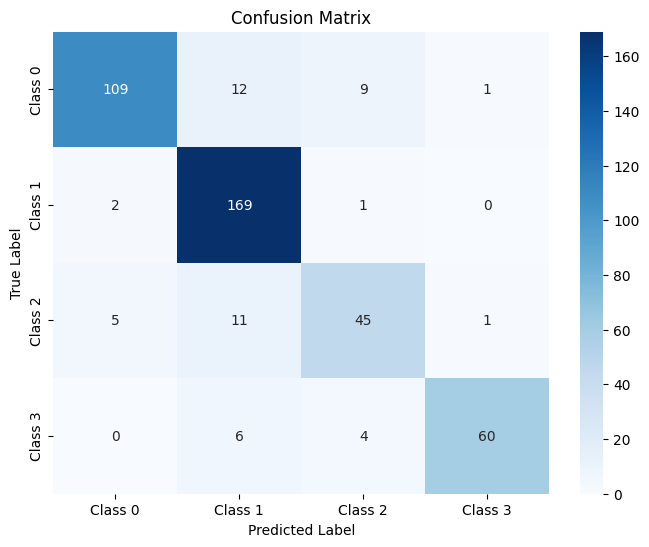

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [56]:
import keras

In [59]:
keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=200, show_layer_activations=True, show_trainable=True)

In [61]:
model.save('i3d_lesion1.h5')

In [63]:
from google.colab import files
files.download('i3d_lesion1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>